# EDA Protocolo Hígado Graso

In [ ]:
# Librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis, skew, shapiro
from sklearn.preprocessing import power_transform
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Archivo del Protocolo
archivo_excel = '/content/drive/MyDrive/protocolo/encuesta.xlsx'
df = pd.read_excel(archivo_excel)

## Preprocesamiento

In [ ]:
# Elimina registros sin información
df = df.dropna(subset=['ta'])
# elimina paciente prueba
df = df[df['nombre'] != 'prueba']
# eliminar la columna de nombre
df = df.drop(columns=['nombre'])
# set id
df = df.set_index('exp')
# completa nulos
# df.info()

In [ ]:
# Muestra solo los mayores a 1 en value_counts
df.reset_index()['exp'].value_counts()[df.reset_index()['exp'].value_counts() > 1]

,count
exp,


In [ ]:
# Elimina duplicados
df = df[~df.index.duplicated(keep='first')]

In [ ]:
# Convierte el campo de diabetes si es SI en 1 y si es NO en 0
df['diabetes'] = df['diabetes'].apply(lambda x: 1 if x == 'SI' else 0)

In [ ]:
# separa la lista en columnas llamadas 'estudio', 'fecha', diagnostico', 'gravedad'
df = df.join(df['dx_masld '].str.split(' ', expand=True).rename(columns={0: 'estudio', 1: 'fecha', 2: 'diagnostico', 3: 'esteatosis'}))
# elimina las columnas 4 y dx_masld
df = df.drop(columns=['dx_masld ', 4])

# obten presion sistolica y diastolica
df = df.join(df['ta'].str.split('/', expand=True).rename(columns={0: 'ta_sistolica', 1: 'ta_diastolica'}))
df['ta_sistolica'] = df['ta_sistolica'].astype(int)
df['ta_diastolica'] = df['ta_diastolica'].astype(int)
# elimina las columnas ta
df = df.drop(columns=['ta'])

In [ ]:
# Medicamentos
df['medicamentos'] = df['medicamentos'].fillna(',')
df['medicamentos'] = df['medicamentos'].str.replace(',', ' ')
df['medicamentos'] = df['medicamentos'].str.split()
df['medicamentos'] = df['medicamentos'].apply(lambda x: [i.upper() for i in x])
df['medicamentos'] = df['medicamentos'].apply(lambda x: [i for i in x if len(i) >= 3])
df['medicamentos'] = df['medicamentos'].apply(lambda x: [i for i in x if i != 'PARA'])
df['medicamentos'].value_counts()

,count
medicamentos,
[],43
[ESTATINAS],24
[METFORMINA],14
[INSULINA],4
"[ESTATINAS, METFORMINA]",3
"[METFORMINA, ESTATINAS]",3
[ATORVASTATINA],2
[LOSARTAN],2
"[TELMISARTAN, ESTATINAS]",1


In [ ]:
# separa los medicamentos en columnas
df = df.join(df['medicamentos'].str.join('|').str.get_dummies())
df = df.drop(columns=['medicamentos'])

In [ ]:
# Agrupa medicamentos
tx_dislipidemia = ['ATORVASTATINA', 'BEZAFIBRATO', 'ESTATINAS', 'EVOLOCUMAB', 'EZETIMIBE', 'FIBRATOS']
df['tx_dislipidemia'] = df[tx_dislipidemia].sum(axis=1)
df.drop(columns=tx_dislipidemia, inplace=True)
tx_has = ['AMLODIPINO', 'HAS', 'LOSARTAN', 'METOPROLOL', 'NIFEDIPINO', 'TELMISARTAN']
df['tx_has'] = df[tx_has].sum(axis=1)
df.drop(columns=tx_has, inplace=True)
tx_dm = ['INSULINA', 'LINAGLIPTINA', 'METFORMINA', 'SITAGLIPTINA']
df['tx_dm'] = df[tx_dm].sum(axis=1)
df.drop(columns=tx_dm, inplace=True)

In [ ]:
# Lista de columnas de dieta
dieta = ['aceite_oliva', 'hojas_verdes', 'verduras', 'frutos_rojos', 'frutas', 'carne_roja', 'pescado', 'pollo', 'queso',
         'mantequilla', 'frijoles', 'cereales', 'dulces', 'nueces', 'comida_rapida', 'alcohol']
print(len(dieta) == df[dieta].shape[1])

True


Funciones para discretizar:

In [ ]:
# Actividad física
def act_fisica(x):
  if x >= 150:
    return 100
  elif x >= 120:
    return 90
  elif x >= 90:
    return 80
  elif x >= 60:
    return 60
  elif x >= 30:
    return 40
  elif x >= 1:
    return 20
  elif x < 1:
    return 0

# Tabaquismo
def tabaquismo(x):
  if x == 'Nunca fumé':
    return 100
  elif x == "Exfumador (dejé de fumar ≥5 años)":
    return 75
  elif x == "Exfumador (dejé de fumar 1–<5 años)":
    return 50
  elif x == "Exfumador (dejé de fumar <1 año o actualmente vapeo)":
    return 25
  elif x == "Fumador actual":
    return 0

# Horas de sueño
def horas_sueño(x):
  if x >= 10:
    return 40
  elif x >= 9:
    return 90
  elif x >= 7:
    return 100
  elif x >= 6:
    return 70
  elif x >= 5:
    return 40
  elif x >= 4:
    return 20
  elif x < 4:
    return 0

# IMC
def imc(x):
  if x >= 40:
    return 0
  elif x >= 35:
    return 15
  elif x >= 30:
    return 30
  elif x >= 25:
    return 70
  elif x < 25:
    return 100

# Colesterol
def colesterol(x):
  if x >= 220:
    return 0
  elif x >= 190:
    return 20
  elif x >= 160:
    return 40
  elif x >= 130:
    return 60
  elif x >= 100:
    return 100

# Diabetes
def diabetes(x, y, z):
  if x == 1 and z >= 10:
    return 0
  elif x == 1 and z >= 9:
    return 10
  elif x == 1 and z >= 8:
    return 20
  elif x == 1 and z >= 7:
    return 30
  elif x == 1 and z < 7:
    return 40
  elif (x == 0 and y >= 100 and y <= 125) or(x == 0 and z >= 5.7 and z <= 6.4):
    return 60
  elif (x == 0 and y < 100) or(x == 0 and z < 5.7):
    return 100

# Presion Arterial
def presion_arterial(x, y):
  if x >= 160 or y >= 100:
    return 0
  elif x >= 140 or y >= 90:
    return 25
  elif x >= 130 or y >= 80:
    return 50
  elif x >= 120:
    return 75
  elif x < 120 or y < 80:
    return 100

# Dieta MEPA Score
def dieta_mepa(x):
  if x >= 15:
    return 100
  elif x >= 12:
    return 80
  elif x >= 8:
    return 50
  elif x >= 4:
    return 25
  elif x < 4:
    return 0

# resultado LE8
def resultado_le8(x):
  if x >= 80:
    return 'ALTA'
  elif x >= 50:
    return 'MODERADA'
  elif x < 50:
    return 'BAJA'


In [ ]:
# Aplica las funciones para discretizar
df['pts_actividad_fisica'] = df['act_fisica_min'].apply(act_fisica)
df['pts_tabaquismo'] = df['tabaquismo'].apply(tabaquismo)
df['pts_horas_sueño'] = df['sueño_hr'].apply(horas_sueño)
df['pts_imc'] = df['imc'].apply(imc)
df['pts_colesterol'] = df['colesterol_total'].apply(colesterol)
df['pts_diabetes'] = df.apply(lambda x: diabetes(x['diabetes'], x['glucosa_serica'], x['hba1c']), axis=1)
df['pts_ta'] = df.apply(lambda x: presion_arterial(x['ta_sistolica'], x['ta_diastolica']), axis=1)
df['pts_dieta'] = df[dieta].sum(axis=1)
df['pts_dieta_mepa'] = df['pts_dieta'].apply(dieta_mepa)

In [ ]:
# Ajusta puntajes por tratamiento
df['pts_colesterol'] = df.apply(lambda x: x['pts_colesterol'] - 20 if x['tx_dislipidemia'] > 0 else x['pts_colesterol'], axis=1)
df['pts_diabetes'] = df.apply(lambda x: x['pts_diabetes'] - 20 if x['tx_dm'] > 0 else x['pts_diabetes'], axis=1)
df['pts_ta'] = df.apply(lambda x: x['pts_ta'] - 20 if x['tx_has'] > 0 else x['pts_ta'], axis=1)

In [ ]:
# Calcula puntaje total
le8 = ['pts_actividad_fisica', 'pts_tabaquismo', 'pts_horas_sueño', 'pts_imc', 'pts_colesterol', 'pts_diabetes', 'pts_ta', 'pts_dieta_mepa']
df['pts_le8'] = df[le8].sum(axis=1) /8
df['salud_cardiovascular'] = df['pts_le8'].apply(resultado_le8)

## EDA

In [ ]:
# Imprime columnas
var_cat = ['tabaquismo', 'tx_dislipidemia', 'tx_has', 'tx_dm', 'salud_cardiovascular']
var_num = ['edad', 'act_fisica_min', 'sueño_hr', 'imc', 'ta_sistolica', 'ta_diastolica', 'colesterol_total',
           'glucosa_serica', 'hba1c']
var_puntajes = ['pts_actividad_fisica', 'pts_tabaquismo', 'pts_horas_sueño', 'pts_imc', 'pts_colesterol', 'pts_diabetes', 'pts_ta', 'pts_dieta_mepa', 'pts_le8']
var_dicotomicas = ['sexo', 'diabetes', 'esteatosis']
print('Categóricas: ', var_cat)
print('Cuantitativas: ', var_num)
print('Dicotómicas: ', var_dicotomicas, dieta)
print('Puntajes: ', var_puntajes)

eliminar = [col for col in df.columns if col not in dieta and col not in var_cat and col not in var_num and col not in var_puntajes and col not in var_dicotomicas]
print('Eliminados: ', eliminar)
df = df.drop(columns=eliminar)

# Convierte a string
df[var_cat] = df[var_cat].astype(str)

Categóricas:  ['tabaquismo', 'tx_dislipidemia', 'tx_has', 'tx_dm', 'salud_cardiovascular']
Cuantitativas:  ['edad', 'act_fisica_min', 'sueño_hr', 'imc', 'ta_sistolica', 'ta_diastolica', 'colesterol_total', 'glucosa_serica', 'hba1c']
Dicotómicas:  ['sexo', 'diabetes', 'esteatosis'] ['aceite_oliva', 'hojas_verdes', 'verduras', 'frutos_rojos', 'frutas', 'carne_roja', 'pescado', 'pollo', 'queso', 'mantequilla', 'frijoles', 'cereales', 'dulces', 'nueces', 'comida_rapida', 'alcohol']
Puntajes:  ['pts_actividad_fisica', 'pts_tabaquismo', 'pts_horas_sueño', 'pts_imc', 'pts_colesterol', 'pts_diabetes', 'pts_ta', 'pts_dieta_mepa', 'pts_le8']
Eliminados:  ['estudio', 'fecha', 'diagnostico', 'pts_dieta']


### Variables dicotómicas

In [ ]:
# cuantifica nulos
print('Proporción de Valores Nulos:')
print((df[var_dicotomicas + dieta].isnull().sum()/df.shape[0]).round(2).sort_values(ascending=False))

Proporción de Valores Nulos:
cereales         0.02
pescado          0.01
pollo            0.01
comida_rapida    0.01
nueces           0.01
dulces           0.01
frijoles         0.01
mantequilla      0.01
queso            0.01
alcohol          0.01
carne_roja       0.01
frutas           0.01
frutos_rojos     0.01
verduras         0.01
hojas_verdes     0.01
aceite_oliva     0.01
diabetes         0.00
esteatosis       0.00
sexo             0.00
dtype: float64


In [ ]:
# Recuentos únicos
for column in (var_dicotomicas + dieta):
    print(df[column].value_counts())
    print('-' * 50)

sexo
FEMENINO     87
MASCULINO    23
Name: count, dtype: int64
--------------------------------------------------
diabetes
0    82
1    28
Name: count, dtype: int64
--------------------------------------------------
esteatosis
LEVE        74
MODERADA    36
Name: count, dtype: int64
--------------------------------------------------
aceite_oliva
0.0    76
1.0    33
Name: count, dtype: int64
--------------------------------------------------
hojas_verdes
1.0    106
0.0      3
Name: count, dtype: int64
--------------------------------------------------
verduras
1.0    93
0.0    16
Name: count, dtype: int64
--------------------------------------------------
frutos_rojos
0.0    88
1.0    21
Name: count, dtype: int64
--------------------------------------------------
frutas
1.0    107
0.0      2
Name: count, dtype: int64
--------------------------------------------------
carne_roja
0.0    95
1.0    14
Name: count, dtype: int64
--------------------------------------------------
pescado
1.0   

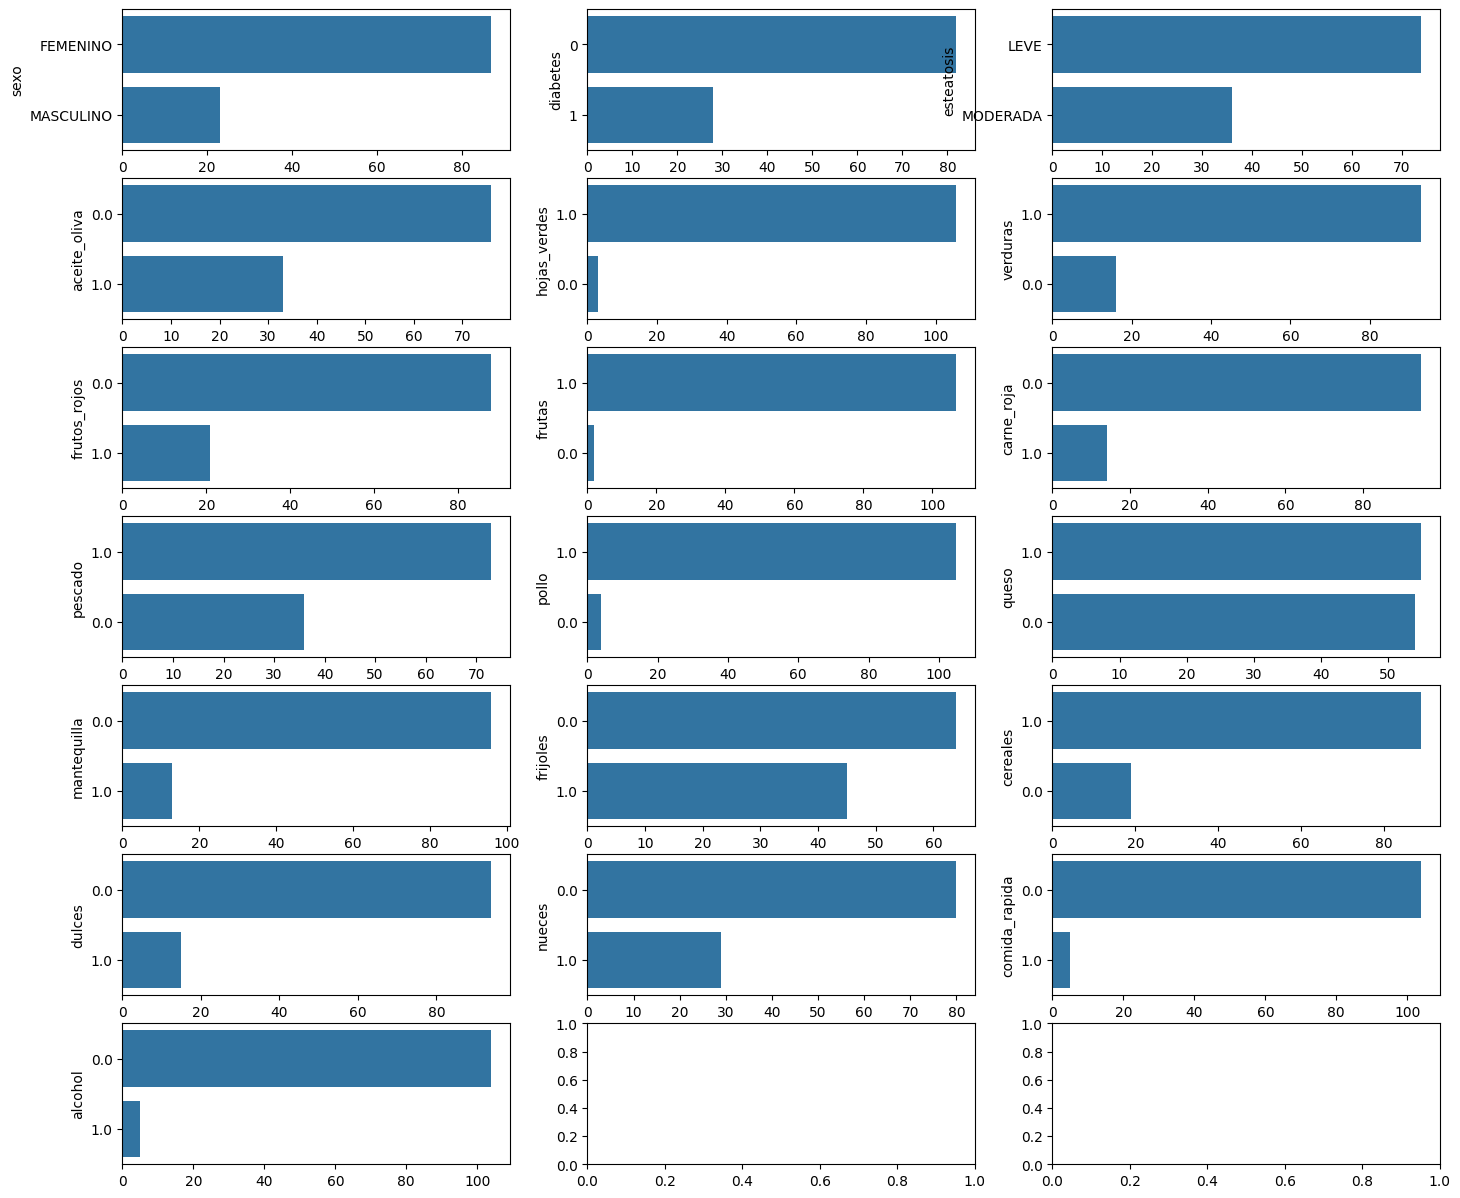

In [ ]:
#Gráficas de recuentos únicos
fig, axes = plt.subplots(7,3, figsize=(17,15))
axes = axes.ravel()
for col, ax in zip(df[var_dicotomicas + dieta], axes):
  sns.countplot(y=df[col], ax=ax, order=df[col].value_counts().index)
  ax.set(xlabel=None)

### Variables Categóricas

In [ ]:
# cuantifica nulos
print('Proporción de Valores Nulos:')
print((df[var_cat].isnull().sum()/df.shape[0]).round(2).sort_values(ascending=False))

Proporción de Valores Nulos:
tabaquismo              0.0
tx_dislipidemia         0.0
tx_has                  0.0
tx_dm                   0.0
salud_cardiovascular    0.0
dtype: float64


In [ ]:
# Recuentos únicos
for column in (var_cat):
    print(df[column].value_counts())
    print('-' * 50)

tabaquismo
Nunca fumé                                              83
Exfumador (dejé de fumar ≥5 años)                       13
Fumador actual                                          10
Exfumador (dejé de fumar 1–<5 años)                      3
Exfumador (dejé de fumar <1 año o actualmente vapeo)     1
Name: count, dtype: int64
--------------------------------------------------
tx_dislipidemia
0    70
1    38
2     2
Name: count, dtype: int64
--------------------------------------------------
tx_has
0    99
1    11
Name: count, dtype: int64
--------------------------------------------------
tx_dm
0    78
1    30
2     1
3     1
Name: count, dtype: int64
--------------------------------------------------
salud_cardiovascular
MODERADA    87
BAJA        18
ALTA         5
Name: count, dtype: int64
--------------------------------------------------


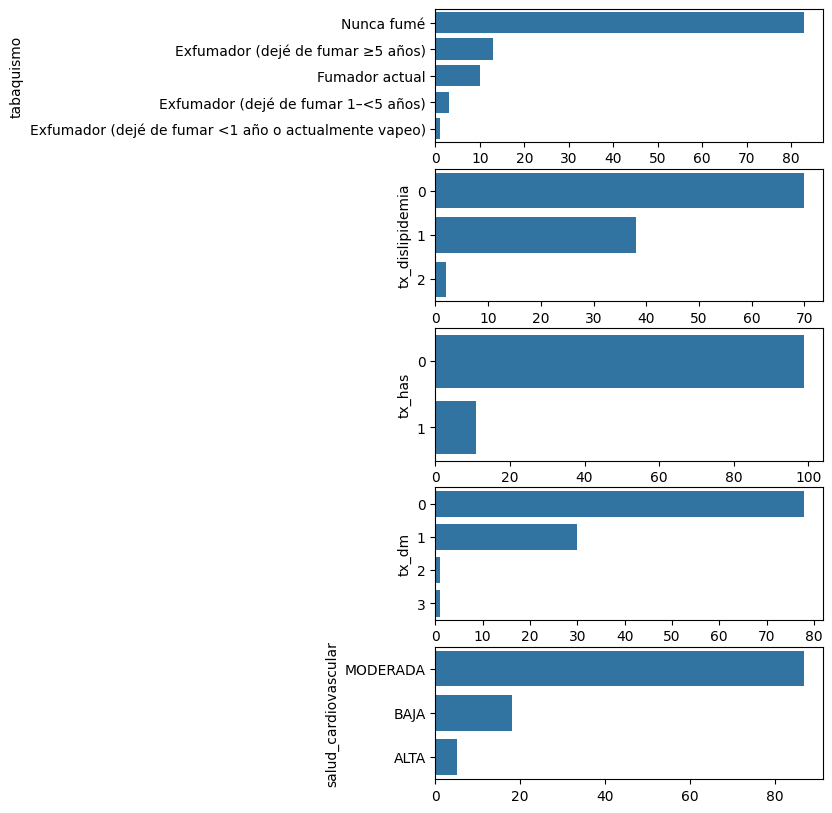

In [ ]:
#Gráficas de recuentos únicos
fig, axes = plt.subplots(5,1, figsize=(5,10))
axes = axes.ravel()
for col, ax in zip(df[var_cat], axes):
  sns.countplot(y=df[col], ax=ax, order=df[col].value_counts().index)
  ax.set(xlabel=None)

###Variables Cuantitativas


In [ ]:
# cuantifica nulos
print('Proporción de Valores Nulos:')
print((df[var_num].isnull().sum()/df.shape[0]).round(2).sort_values(ascending=False))
print('\nProporción de Valores Nulos:')
print((df[var_puntajes].isnull().sum()/df.shape[0]).round(2).sort_values(ascending=False))

Proporción de Valores Nulos:
hba1c               0.01
edad                0.00
act_fisica_min      0.00
sueño_hr            0.00
imc                 0.00
ta_sistolica        0.00
ta_diastolica       0.00
colesterol_total    0.00
glucosa_serica      0.00
dtype: float64

Proporción de Valores Nulos:
pts_colesterol          0.03
pts_diabetes            0.02
pts_actividad_fisica    0.00
pts_tabaquismo          0.00
pts_horas_sueño         0.00
pts_imc                 0.00
pts_ta                  0.00
pts_dieta_mepa          0.00
pts_le8                 0.00
dtype: float64


In [ ]:
def shapiro_wilk_test(data):
    """
    Realiza la prueba de Shapiro-Wilk para verificar la normalidad de una muestra de datos.

    Parámetros:
    - data: array-like, la muestra de datos a evaluar.

    Retorna:
    - stat: float, el valor del estadístico W de Shapiro-Wilk.
    - p_value: float, el valor p asociado a la prueba.
    """
    # Eliminar valores faltantes
    data = data.dropna()

    # Asegurarse de que hay suficientes datos
    if len(data) < 3:
        return np.nan, np.nan

    # Calcular la prueba de Shapiro-Wilk
    stat, p_value = shapiro(data)

    return stat, p_value


In [ ]:
def shapiro_test(data):
    data = data.dropna()  # Ignorar valores faltantes
    if len(data) < 3:  # Asegurarse de que hay suficientes datos
        return np.nan, np.nan
    stat, p_value = shapiro(data)
    return stat, p_value

def stats(x):
  stats = x.describe().T
  stats['kurt'] = x.kurtosis()
  stats['skew'] = x.skew()
  shapiro_results = x.apply(shapiro_test)
  stats['W-Value (Shapiro-Wilk)'] = shapiro_results.apply(lambda x: x[0])
  stats['P-Value (Shapiro-Wilk)'] = shapiro_results.apply(lambda x: x[1]).round(3)
  stats['Normal Distribution (Shapiro-Wilk)'] = stats['P-Value (Shapiro-Wilk)'].apply(lambda p: 1 if not np.isnan(p) and p > 0.05 else 0)
  return stats

In [ ]:
stats(df[var_num])

,count,mean,std,min,25%,50%,75%,max,kurt,skew,W-Value (Shapiro-Wilk),P-Value (Shapiro-Wilk),Normal Distribution (Shapiro-Wilk)
edad,110.0,55.809091,10.921316,19.0,52.25,57.0,63.00,85.0,2.156785,-1.024058,0.925633,0.000,0
act_fisica_min,110.0,156.136364,144.846738,0.0,41.25,130.0,240.00,720.0,2.305505,1.258209,0.882820,0.000,0
sueño_hr,110.0,6.245455,1.068192,4.0,6.00,6.0,7.00,8.0,-0.263586,-0.415600,0.898631,0.000,0
imc,110.0,27.950000,4.481906,19.8,25.00,25.6,31.00,40.3,-0.494383,0.690418,0.912185,0.000,0
ta_sistolica,110.0,115.472727,15.904364,74.0,106.00,113.0,125.75,156.0,0.072896,0.332460,0.979808,0.094,1
ta_diastolica,110.0,73.918182,8.995546,53.0,68.00,72.5,80.00,97.0,0.022445,0.342001,0.984079,0.215,1
colesterol_total,110.0,168.890909,42.915822,50.0,137.50,170.0,199.00,283.0,-0.185985,0.147829,0.989919,0.591,1
glucosa_serica,110.0,98.486364,20.614912,64.0,87.00,94.0,105.00,196.0,6.230124,2.050779,0.833247,0.000,0
hba1c,109.0,5.839450,0.732957,4.7,5.30,5.8,6.00,9.2,6.254833,1.910924,0.854227,0.000,0


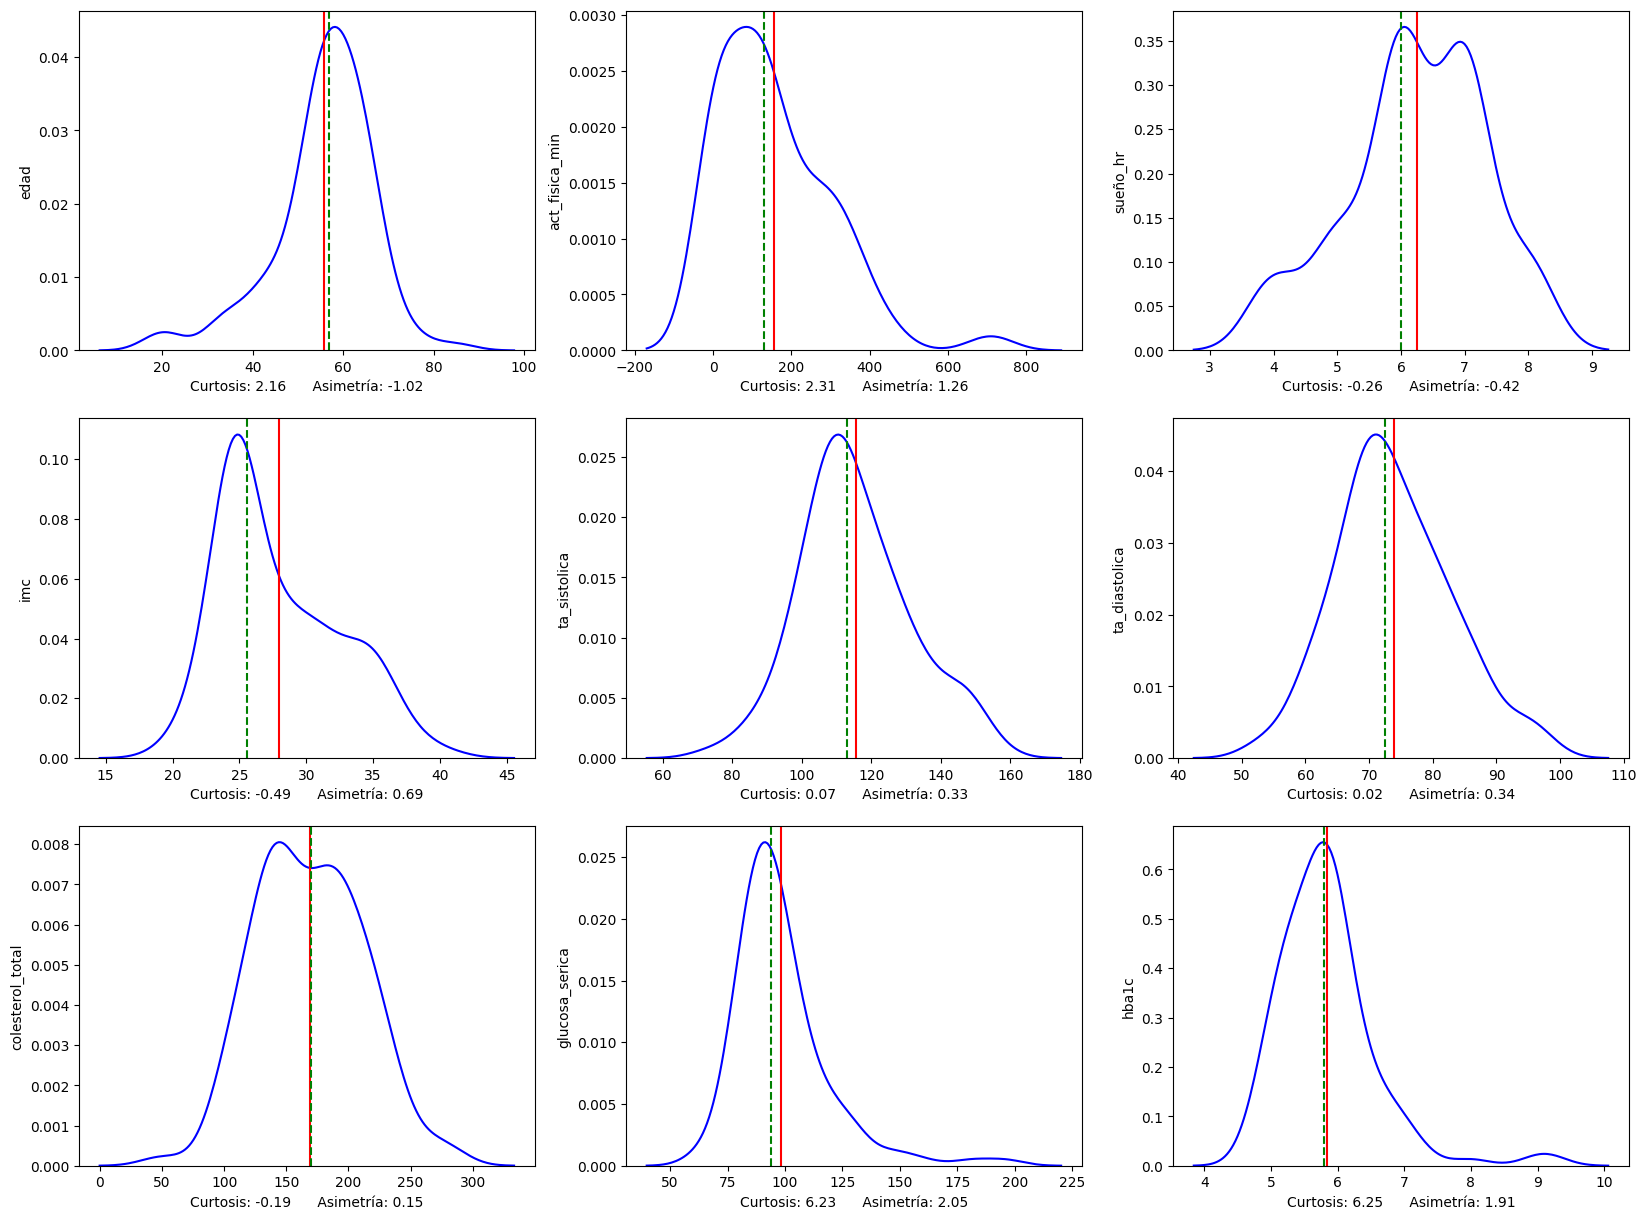

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,15))
axes = axes.ravel()

for col, ax in zip(df[var_num], axes):
  sns.kdeplot(df[col], color = 'Blue', ax=ax)
  ax.axvline(df[col].mean(), color='red')
  ax.axvline(df[col].median(), color='green', linestyle='--')
  ax.set(ylabel = f'{col}', xlabel = 'Curtosis: '+str(round(df[col].kurt(),2)) + "      Asimetría: " + str(round(df[col].skew(),2)))

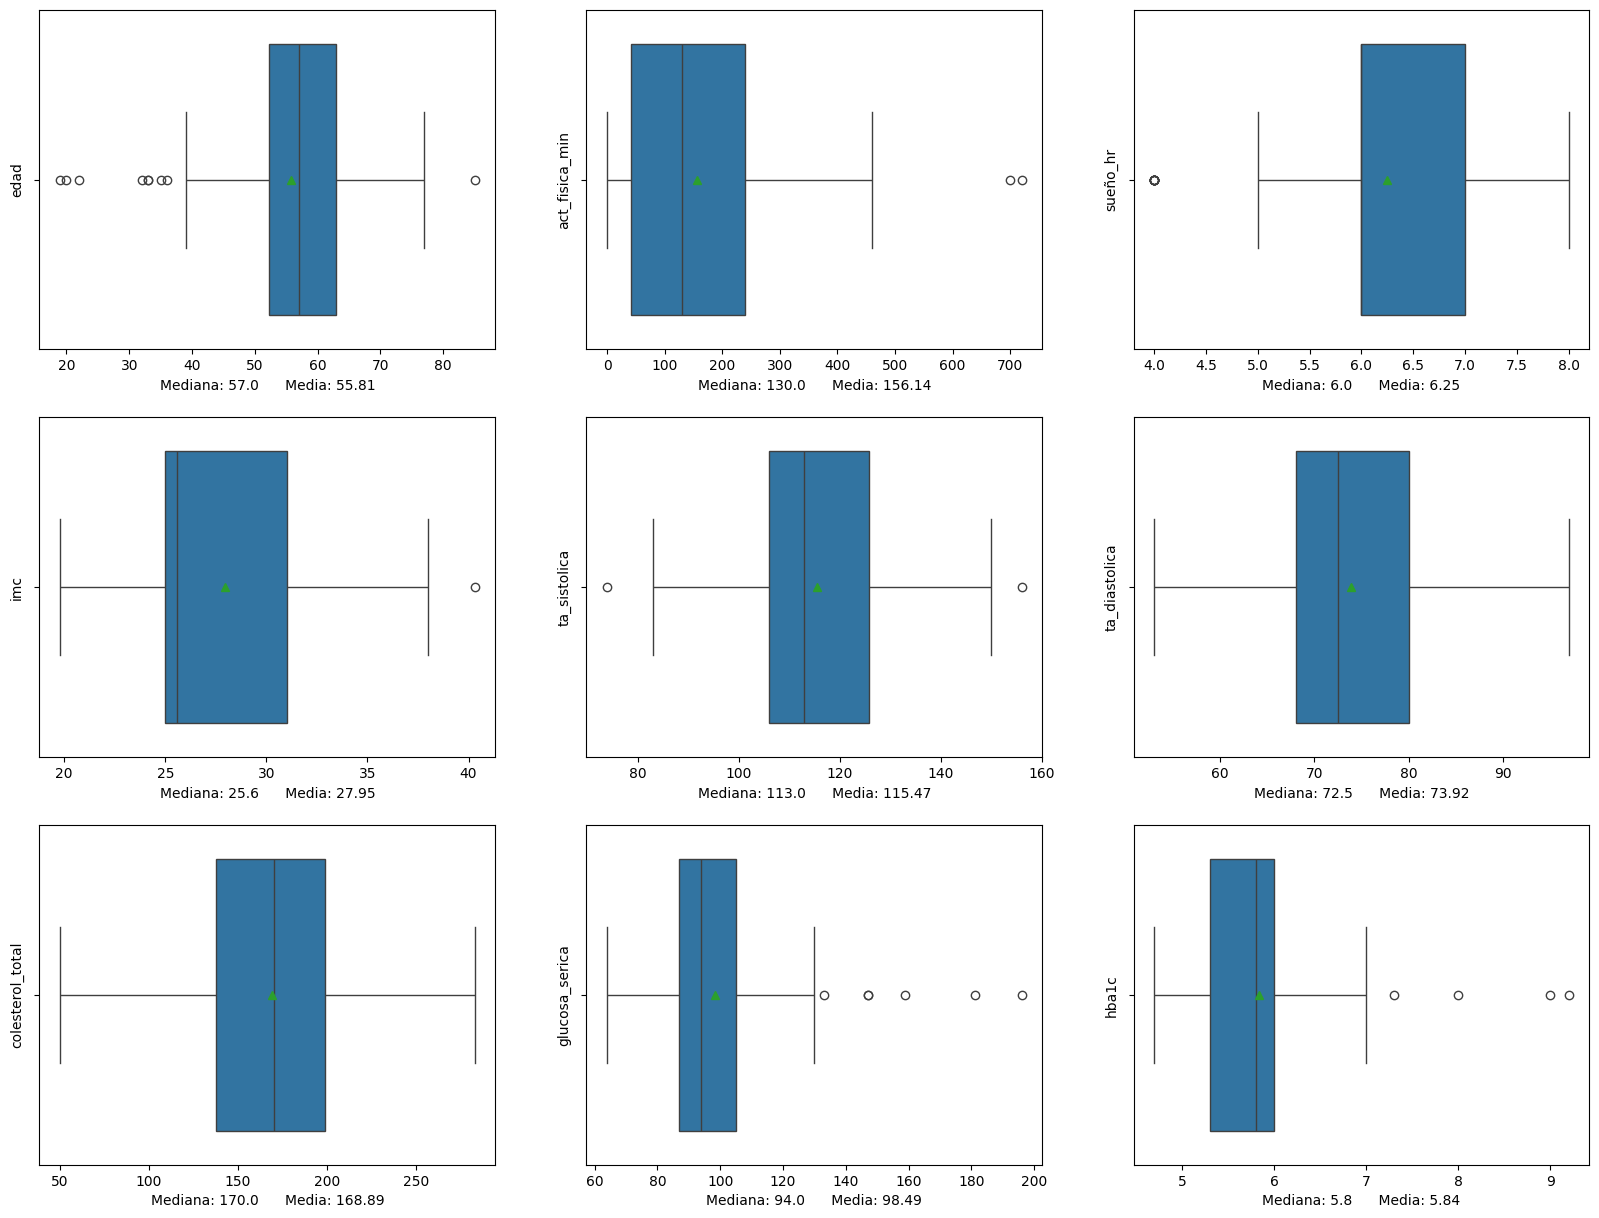

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,15))
axes = axes.ravel()

for col, ax in zip(df[var_num], axes):
  sns.boxplot(x=df[col], showmeans=True, ax=ax)
  ax.set(ylabel = f'{col}', xlabel = 'Mediana: '+str(round(df[col].median(),2)) + "      Media: " + str(round(df[col].mean(),2)))

In [ ]:
stats(df[var_puntajes])

,count,mean,std,min,25%,50%,75%,max,kurt,skew,W-Value (Shapiro-Wilk),P-Value (Shapiro-Wilk),Normal Distribution (Shapiro-Wilk)
pts_actividad_fisica,110.0,69.090909,40.468483,0.00,40.000,90.00,100.0000,100.00,-0.886864,-0.924207,0.707259,0.000,0
pts_tabaquismo,110.0,85.909091,30.199503,0.00,100.000,100.00,100.0000,100.00,3.522473,-2.201832,0.514147,0.000,0
pts_horas_sueño,110.0,75.181818,26.291653,20.00,70.000,70.00,100.0000,100.00,-0.586330,-0.716517,0.803577,0.000,0
pts_imc,110.0,61.818182,29.231183,0.00,30.000,70.00,70.0000,100.00,-1.103651,-0.295616,0.849922,0.000,0
pts_colesterol,107.0,38.691589,32.304101,-20.00,20.000,40.00,60.0000,100.00,-0.514699,0.066856,0.946445,0.000,0
pts_diabetes,108.0,61.111111,30.550505,-10.00,40.000,60.00,100.0000,100.00,-1.061523,-0.113221,0.866206,0.000,0
pts_ta,110.0,76.636364,29.847541,5.00,50.000,100.00,100.0000,100.00,-0.835342,-0.827639,0.750481,0.000,0
pts_dieta_mepa,110.0,37.500000,13.439467,0.00,25.000,50.00,50.0000,50.00,-1.125720,-0.360884,0.687405,0.000,0
pts_le8,110.0,62.971591,12.259494,28.75,55.625,63.75,72.1875,88.75,-0.320842,-0.440037,0.975869,0.043,0


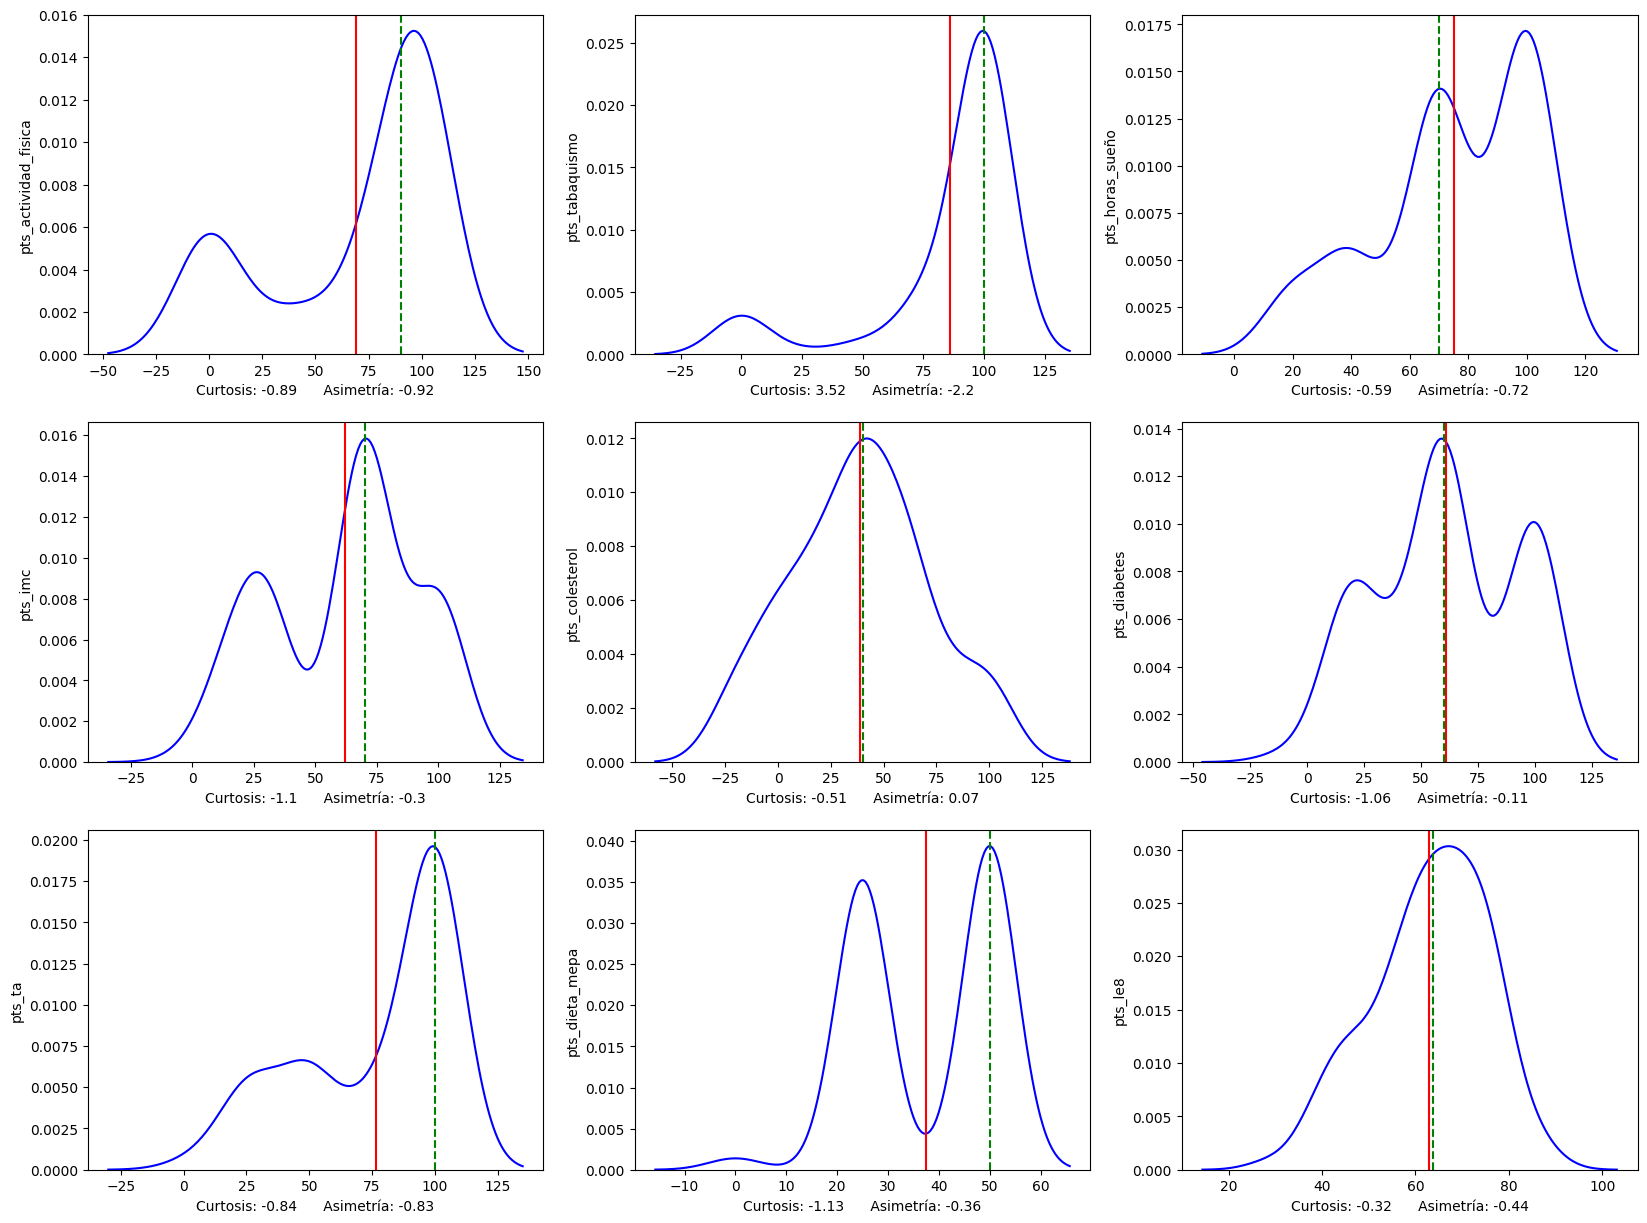

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,15))
axes = axes.ravel()

for col, ax in zip(df[var_puntajes], axes):
  sns.kdeplot(df[col], color = 'Blue', ax=ax)
  ax.axvline(df[col].mean(), color='red')
  ax.axvline(df[col].median(), color='green', linestyle='--')
  ax.set(ylabel = f'{col}', xlabel = 'Curtosis: '+str(round(df[col].kurt(),2)) + "      Asimetría: " + str(round(df[col].skew(),2)))

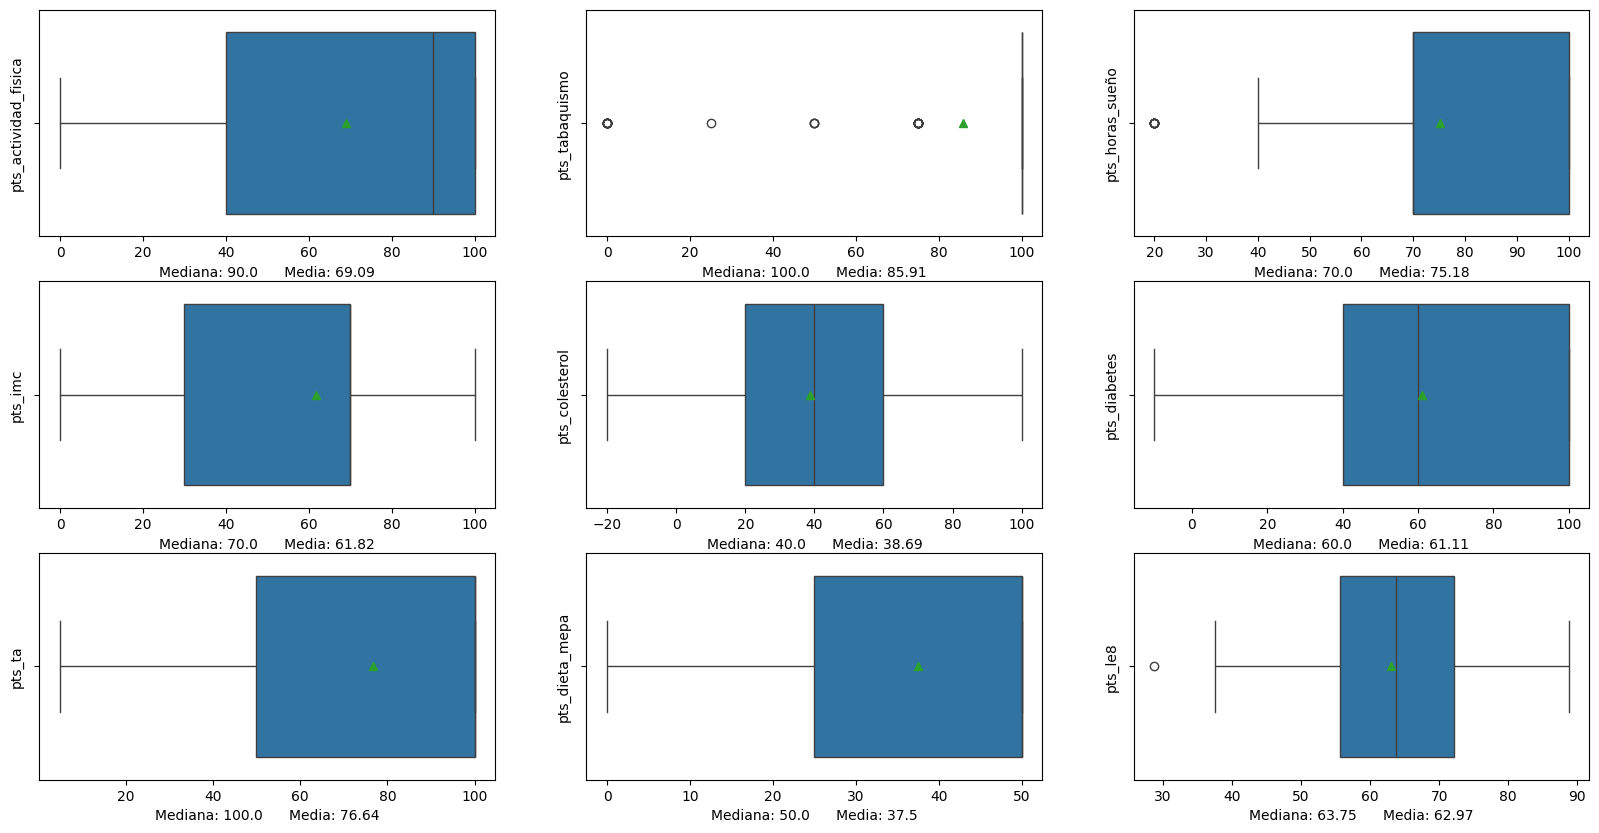

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,10))
axes = axes.ravel()

for col, ax in zip(df[var_puntajes], axes):
  sns.boxplot(x=df[col], showmeans=True, ax=ax)
  ax.set(ylabel = f'{col}', xlabel = 'Mediana: '+str(round(df[col].median(),2)) + "      Media: " + str(round(df[col].mean(),2)))

###Análisis Multivariado

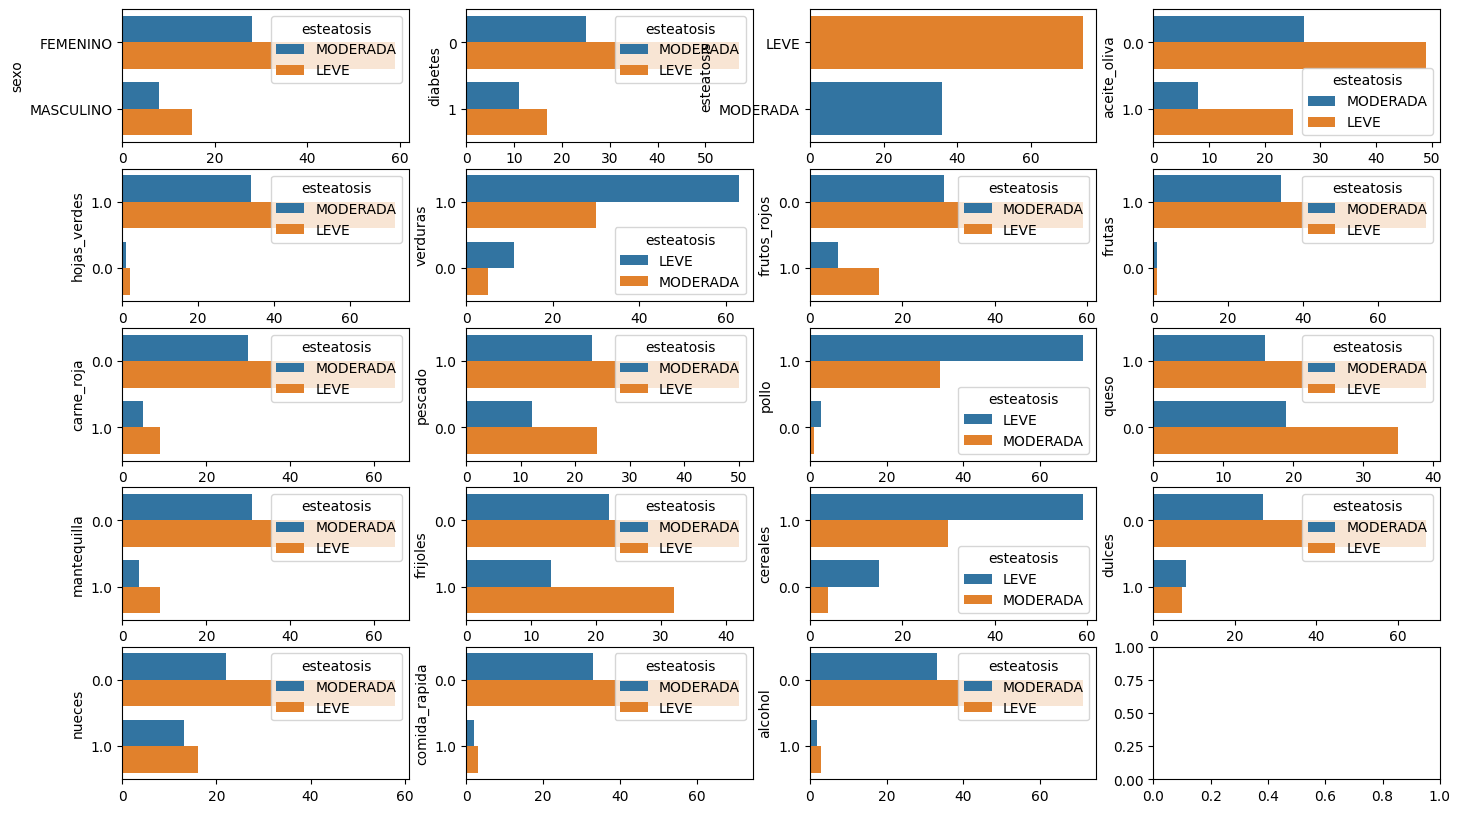

In [ ]:
#Gráficas de recuentos únicos
fig, axes = plt.subplots(5,4, figsize=(17,10))
axes = axes.ravel()
for col, ax in zip(df[var_dicotomicas + dieta], axes):
  sns.countplot(y=df[col], ax=ax, order=df[col].value_counts().index, hue = df['esteatosis'])
  ax.set(xlabel=None)

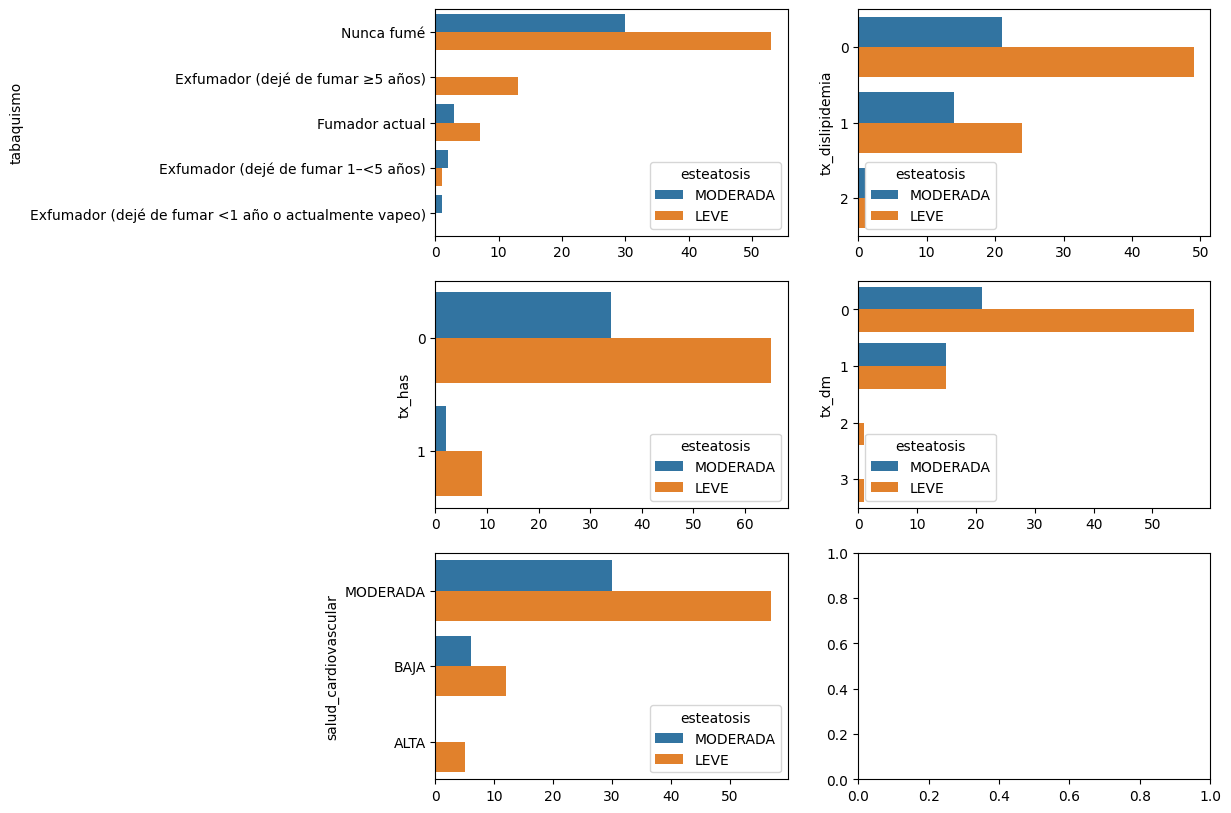

In [ ]:
#Gráficas de recuentos únicos
fig, axes = plt.subplots(3,2, figsize=(10,10))
axes = axes.ravel()
for col, ax in zip(df[var_cat], axes):
  sns.countplot(y=df[col], ax=ax, order=df[col].value_counts().index, hue = df['esteatosis'])
  ax.set(xlabel=None)

<Axes: >

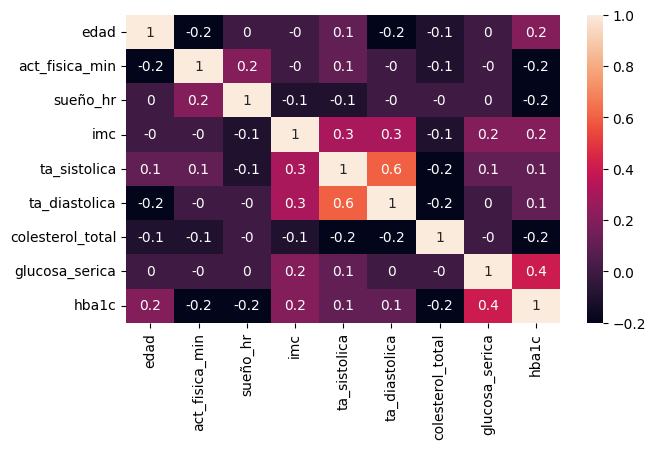

In [ ]:
# Mapa de calor de las correlaciones entre variables cuantitativas
plt.figure(figsize = (7, 4))
sns.heatmap(round(df[var_num].corr(numeric_only=True),1), annot = True)

#### Puntajes

<Axes: >

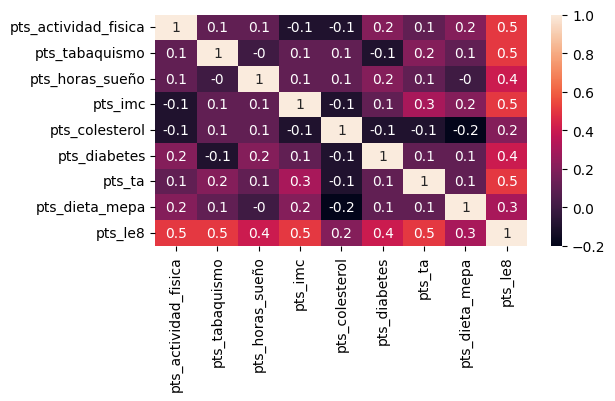

In [ ]:
# Mapa de calor de las correlaciones entre variables cuantitativas
plt.figure(figsize = (6, 3))
sns.heatmap(round(df[var_puntajes].corr(numeric_only=True),1), annot = True)

## Estadística Inferencial

**Prueba U Mann-Whitney:** Comparación de dos grupos independientes sin distribución normal.

In [ ]:
from scipy.stats import mannwhitneyu

def prueba_mannwhitney(df, variables, categoria, grupo1, grupo2):
    all_results = []
    for variable in variables:
        grp1 = df.loc[df[categoria] == grupo1, variable].dropna()
        grp2 = df.loc[df[categoria] == grupo2, variable].dropna()

        # Calcular la prueba de Mann-Whitney U
        stat, p_value = mannwhitneyu(grp1, grp2)

        # Interpretar
        alpha = 0.05
        if p_value > alpha:
            interpretation = 'Same distribution (fail to reject H0)'
        else:
            interpretation = 'Different distribution (reject H0)'

        results = pd.DataFrame({'Variable': variable,
                                'Descriptor': categoria,
                                'Statistics': stat,
                                'p': p_value,
                                'alpha': alpha,
                                'Interpretation': interpretation}, index=[0])
        all_results.append(results)

    # Combina todos los resultados en un solo DataFrame
    final_results = pd.concat(all_results, ignore_index=True)

    return final_results

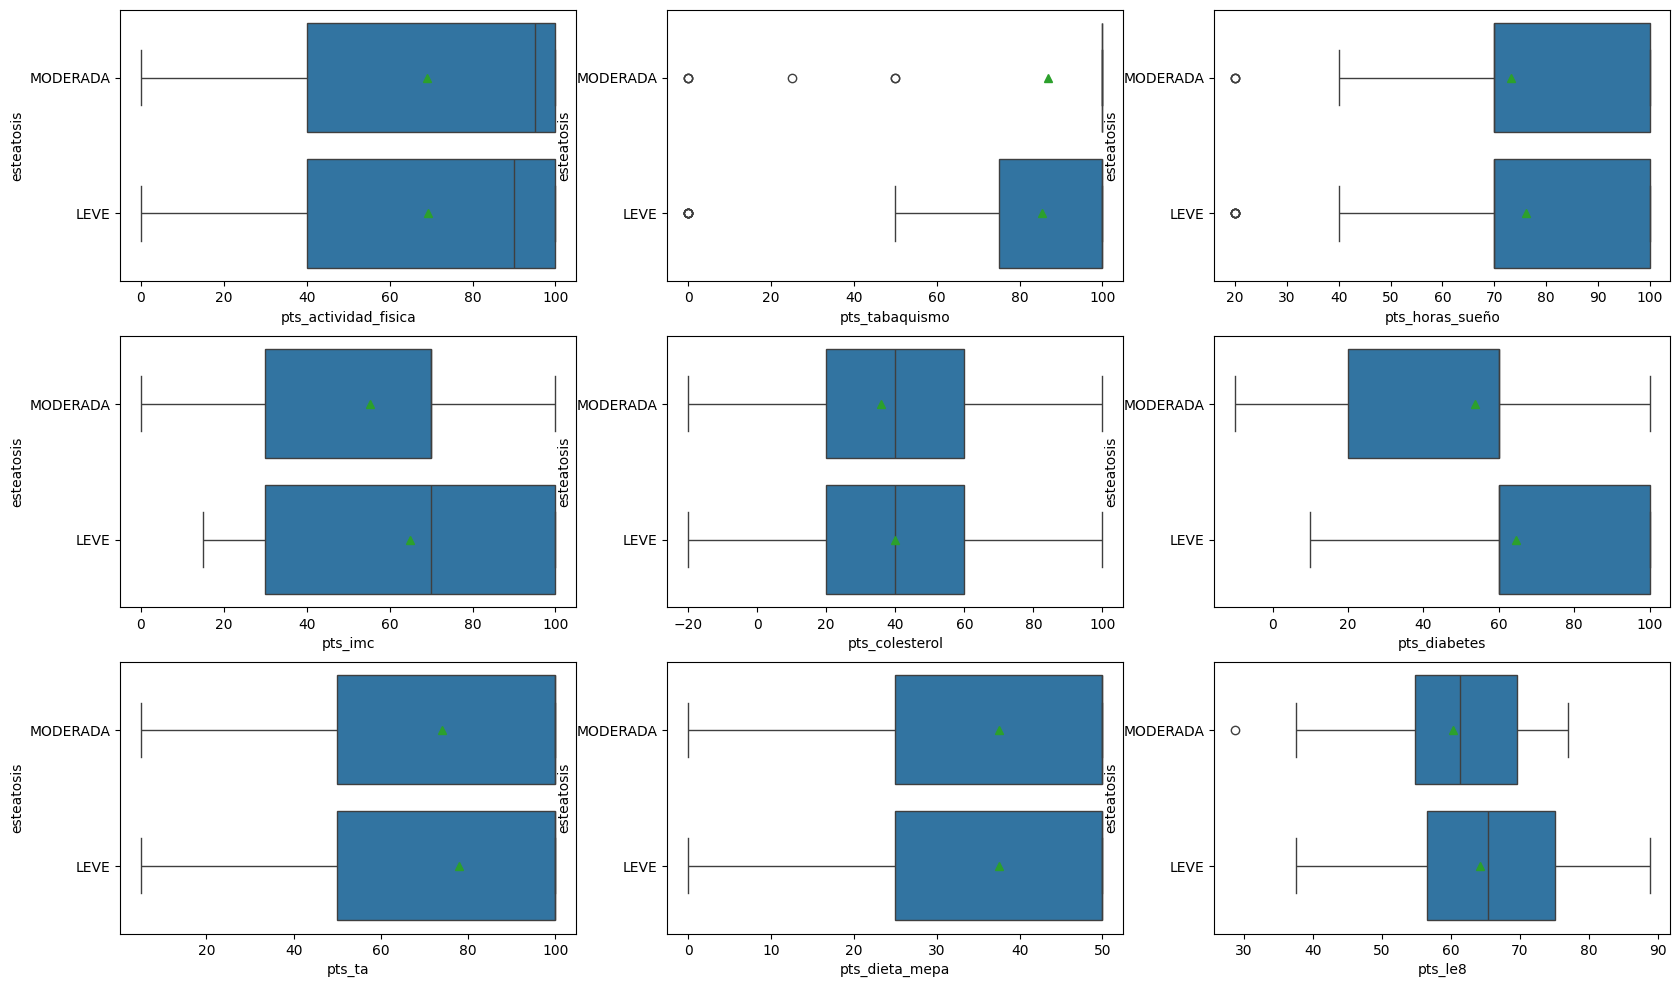

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,12))
axes = axes.ravel()

for col, ax in zip(df[var_puntajes], axes):
  sns.boxplot(x=df[col], y=df['esteatosis'], showmeans=True, ax=ax)

In [ ]:
prueba_mannwhitney(df, var_puntajes, 'esteatosis', 'LEVE', 'MODERADA')

,Variable,Descriptor,Statistics,p,alpha,Interpretation
0,pts_actividad_fisica,esteatosis,1321.0,0.942744,0.05,Same distribution (fail to reject H0)
1,pts_tabaquismo,esteatosis,1206.5,0.290722,0.05,Same distribution (fail to reject H0)
2,pts_horas_sueño,esteatosis,1436.5,0.477475,0.05,Same distribution (fail to reject H0)
3,pts_imc,esteatosis,1582.0,0.091944,0.05,Same distribution (fail to reject H0)
4,pts_colesterol,esteatosis,1323.5,0.669927,0.05,Same distribution (fail to reject H0)
5,pts_diabetes,esteatosis,1532.0,0.080895,0.05,Same distribution (fail to reject H0)
6,pts_ta,esteatosis,1396.0,0.655734,0.05,Same distribution (fail to reject H0)
7,pts_dieta_mepa,esteatosis,1322.5,0.947608,0.05,Same distribution (fail to reject H0)
8,pts_le8,esteatosis,1573.5,0.124605,0.05,Same distribution (fail to reject H0)


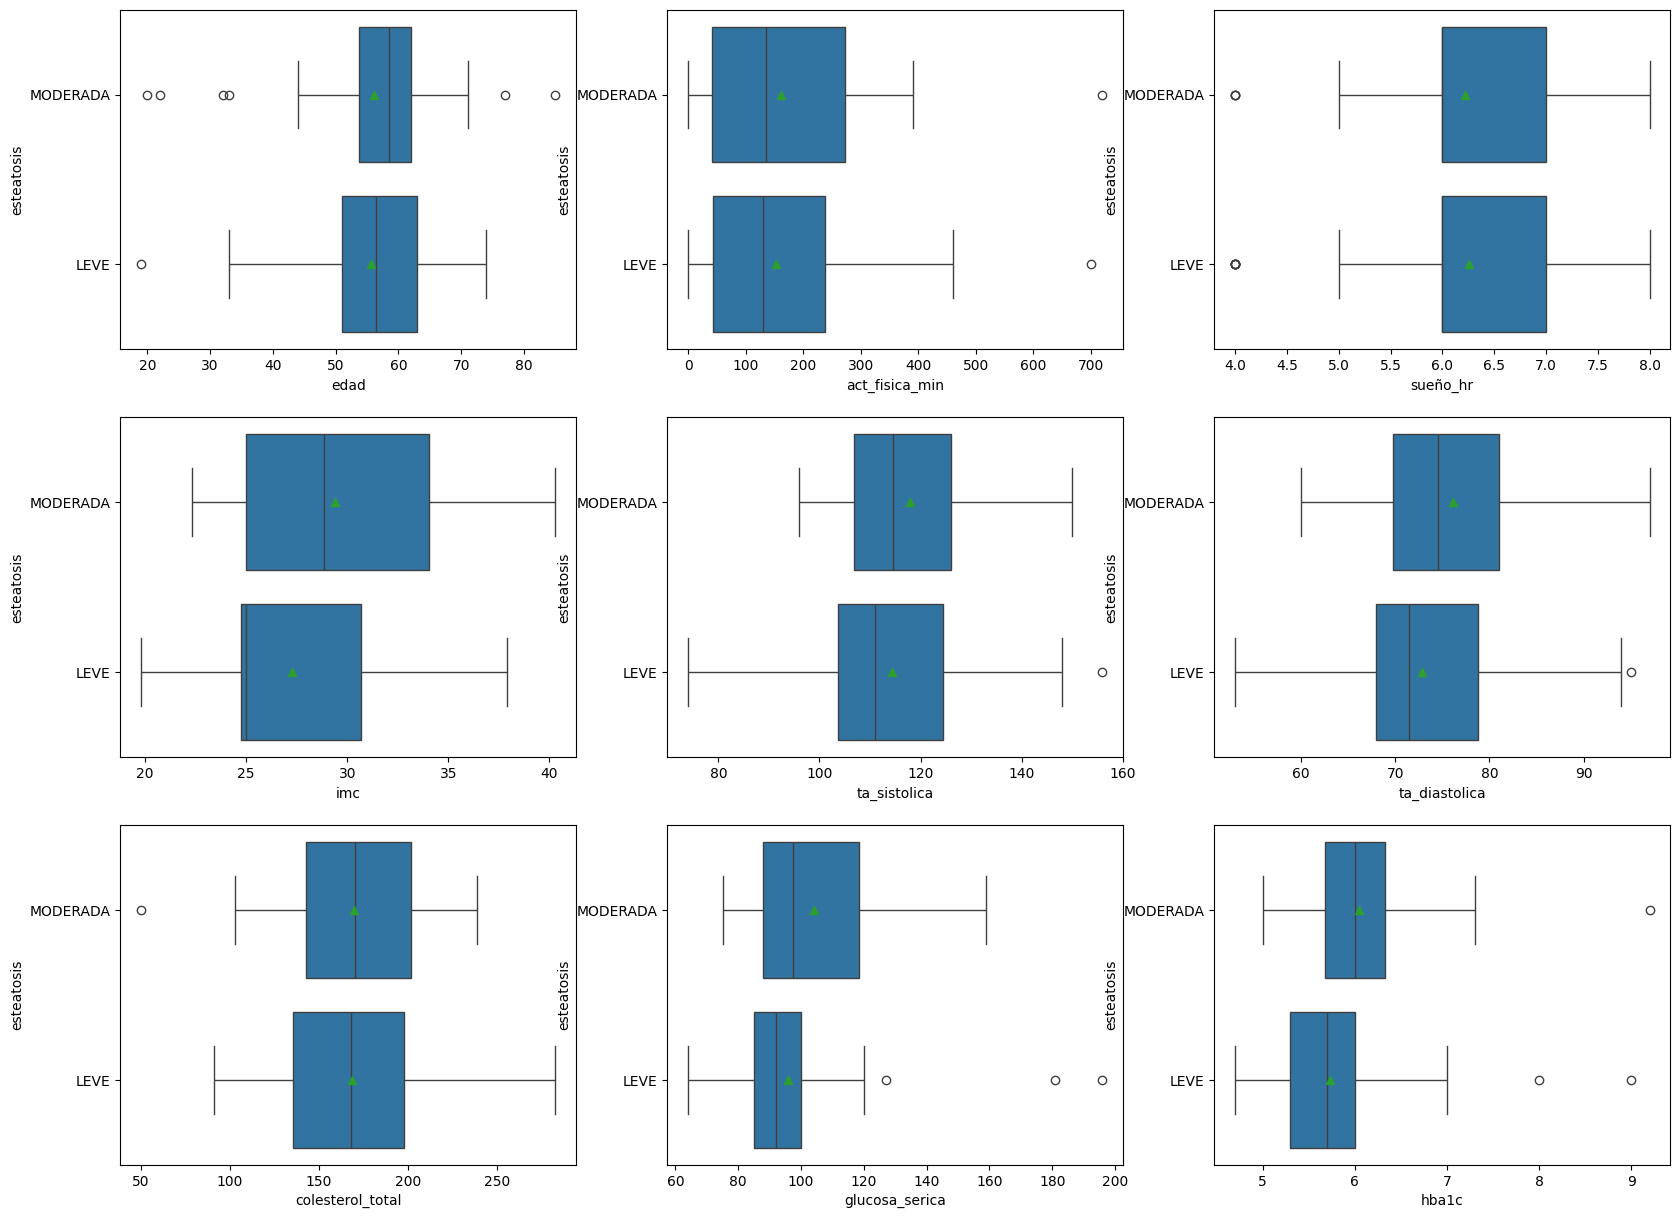

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(20,15))
axes = axes.ravel()

for col, ax in zip(df[var_num], axes):
  sns.boxplot(x=df[col], y=df['esteatosis'], showmeans=True, ax=ax)
  # ax.set(ylabel = f'{col}')

In [ ]:
prueba_mannwhitney(df, var_num, 'esteatosis', 'LEVE', 'MODERADA')

,Variable,Descriptor,Statistics,p,alpha,Interpretation
0,edad,esteatosis,1286.0,0.771706,0.05,Same distribution (fail to reject H0)
1,act_fisica_min,esteatosis,1299.0,0.834818,0.05,Same distribution (fail to reject H0)
2,sueño_hr,esteatosis,1388.0,0.711498,0.05,Same distribution (fail to reject H0)
3,imc,esteatosis,975.0,0.021740,0.05,Different distribution (reject H0)
4,ta_sistolica,esteatosis,1229.5,0.515614,0.05,Same distribution (fail to reject H0)
5,ta_diastolica,esteatosis,1079.0,0.107370,0.05,Same distribution (fail to reject H0)
6,colesterol_total,esteatosis,1256.0,0.630509,0.05,Same distribution (fail to reject H0)
7,glucosa_serica,esteatosis,1038.5,0.061866,0.05,Same distribution (fail to reject H0)
8,hba1c,esteatosis,925.5,0.012138,0.05,Different distribution (reject H0)


,Variable,Descriptor,Statistics,p,alpha,Interpretation
0,pts_le8,delgados,2034.0,0.001836,0.05,Different distribution (reject H0)


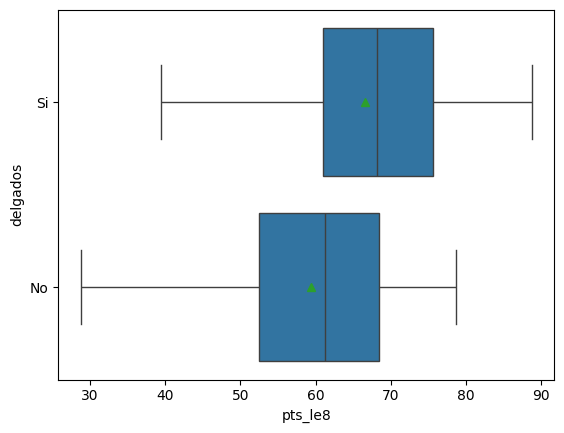

In [ ]:
# crear la columna 'obesidad y asigar valor de 1 si imc >25
df['delgados'] = df['imc'].apply(lambda x: 'Si' if x <= 25 else 'No')
sns.boxplot(x=df['pts_le8'], y=df['delgados'], showmeans=True)
prueba_mannwhitney(df, ['pts_le8'], 'delgados', 'Si', 'No')

In [ ]:
prueba_mannwhitney(df, var_puntajes, 'delgados', 'Si', 'No')

,Variable,Descriptor,Statistics,p,alpha,Interpretation
0,pts_actividad_fisica,delgados,1406.5,4.982774e-01,0.05,Same distribution (fail to reject H0)
1,pts_tabaquismo,delgados,1439.5,5.652463e-01,0.05,Same distribution (fail to reject H0)
2,pts_horas_sueño,delgados,1575.0,6.910596e-01,0.05,Same distribution (fail to reject H0)
3,pts_imc,delgados,2740.0,7.399902e-15,0.05,Different distribution (reject H0)
4,pts_colesterol,delgados,1307.5,4.348638e-01,0.05,Same distribution (fail to reject H0)
5,pts_diabetes,delgados,1681.0,1.523526e-01,0.05,Same distribution (fail to reject H0)
6,pts_ta,delgados,1809.5,5.076407e-02,0.05,Same distribution (fail to reject H0)
7,pts_dieta_mepa,delgados,1755.5,9.660349e-02,0.05,Same distribution (fail to reject H0)
8,pts_le8,delgados,2034.0,1.835818e-03,0.05,Different distribution (reject H0)


Descarga del dataset

In [63]:
# Exporta lista de precios
ruta = archivo_excel = '/content/drive/MyDrive/protocolo/'
archivo = 'datos_procesados.csv'
df.reset_index().to_csv(ruta + archivo, index=False)